In [45]:
import tensorflow as tf
import numpy as np
import os
import time

### SOURCE TEXT LOADING
- loading .txt
- printing the beginning, number of characters, number of unique characters
    

In [ ]:
with open("sources/ring.txt", "r") as f:
    source = f.read()
print(source[:300])

THE  FELLOWSHIP 
OF  THE  RING 


BEING  THE  FIRST  PART 
OF 

The  Lord  of  the  Rings 


BOOK  ONE 


Chapter  I 


A  LONG-EXPECTED  PARTY 


When  Mr.  Bilbo  Baggins  of  Bag  End  announced  that  he 
would  shortly  be  celebrating  his  eleventy-first  birthday  with 
a  party  of  special


In [47]:
print ('{} characters'.format(len(source)))

1145534 characters


In [48]:
vocab = sorted(set(source))
print ('{} unique characters'.format(len(vocab)))

88 unique characters


In [49]:
# unique characters to indices mapping
char2index = {u:i for i, u in enumerate(vocab)}
index2char = np.array(vocab)

text_as_int = np.array([char2index[c] for c in source])

print(text_as_int)

[45 33 30 ...  1  0  0]


In [50]:
print ('{} -- characters mapped to int -- > {}'.format(repr(source[:13]), text_as_int[:13]))

'THE  FELLOWSH' -- characters mapped to int -- > [45 33 30  1  1 31 30 37 37 40 48 44 33]


### DATASET PREPROCESSING
- character to index mapping and converting text to numerical representation
- defining max input sequence length
- creating TensorFlow Dataset from the source
- creating batches from dataset
- input-target split function (:-1 is input, and last element is expected value)
- applying input-target split function to each batch

In [51]:
seq_length = 100
examples_per_epoch = len(source)//(seq_length+1)

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
  print(index2char[i.numpy()])


T
H
E
 
 


In [52]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
  print(repr(''.join(index2char[item.numpy()])))

'THE  FELLOWSHIP \nOF  THE  RING \n\n\nBEING  THE  FIRST  PART \nOF \n\nThe  Lord  of  the  Rings \n\n\nBOOK  ON'
'E \n\n\nChapter  I \n\n\nA  LONG-EXPECTED  PARTY \n\n\nWhen  Mr.  Bilbo  Baggins  of  Bag  End  announced  tha'
't  he \nwould  shortly  be  celebrating  his  eleventy-first  birthday  with \na  party  of  special  m'
'agnificence,  there  was  much  talk  and \nexcitement  in  Hobbiton. \n\nBilbo  was  very  rich  and  v'
'ery  peculiar,  and  had  been  the \nwonder  of  the  Shire  for  sixty  years,  ever  since  his  re'


In [53]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

### PARAMETERS
- training parameters & data shuffling
- model hyperparameters

In [54]:
BATCH_SIZE = 2048
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset element_spec=(TensorSpec(shape=(2048, 100), dtype=tf.int64, name=None), TensorSpec(shape=(2048, 100), dtype=tf.int64, name=None))>

In [55]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 300 #256

# Number of RNN units
rnn_units1 = 256
rnn_units2 = 256
rnn_units=[rnn_units1, rnn_units2]
print(vocab_size)

88


### BUILDING MODEL
- GRU, LSTM, RNN, with Conv1

In [56]:
# ORIGINAL GRU
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units1,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.GRU(rnn_units2,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [60]:
model = build_model(
  vocab_size = vocab_size,
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [61]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (2048, None, 300)         26400     
                                                                 
 gru_4 (GRU)                 (2048, None, 256)         428544    
                                                                 
 gru_5 (GRU)                 (2048, None, 256)         394752    
                                                                 
 dense_2 (Dense)             (2048, None, 88)          22616     
                                                                 
Total params: 872,312
Trainable params: 872,312
Non-trainable params: 0
_________________________________________________________________


### MODEL TRAINING
- optimizer & loss function declaration
- compilation
- epochs number
- launching the training

In [62]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [63]:
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [64]:
checkpoint_dir = './checkpoints_GRU'        # TODO: remember to choose proper directory
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [65]:
EPOCHS=200

In [66]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/200
5/5 [==============================] - 37s 6s/step - loss: 4.3181 - accuracy: 0.2425
Epoch 2/200
5/5 [==============================] - 28s 5s/step - loss: 3.4528 - accuracy: 0.3009
Epoch 3/200
5/5 [==============================] - 27s 5s/step - loss: 3.0775 - accuracy: 0.3009
Epoch 4/200
5/5 [==============================] - 27s 5s/step - loss: 2.9523 - accuracy: 0.3008
Epoch 5/200
5/5 [==============================] - 24s 5s/step - loss: 2.9011 - accuracy: 0.3007
Epoch 6/200
5/5 [==============================] - 24s 5s/step - loss: 2.8704 - accuracy: 0.3008
Epoch 7/200
5/5 [==============================] - 24s 5s/step - loss: 2.8404 - accuracy: 0.3008
Epoch 8/200
5/5 [==============================] - 24s 5s/step - loss: 2.8031 - accuracy: 0.3007
Epoch 9/200
5/5 [==============================] - 24s 5s/step - loss: 2.7495 - accuracy: 0.3004
Epoch 10/200
5/5 [==============================] - 24s 5s/step - loss: 2.6715 - accuracy: 0.3168
Epoch 11/200
5/5 [===========

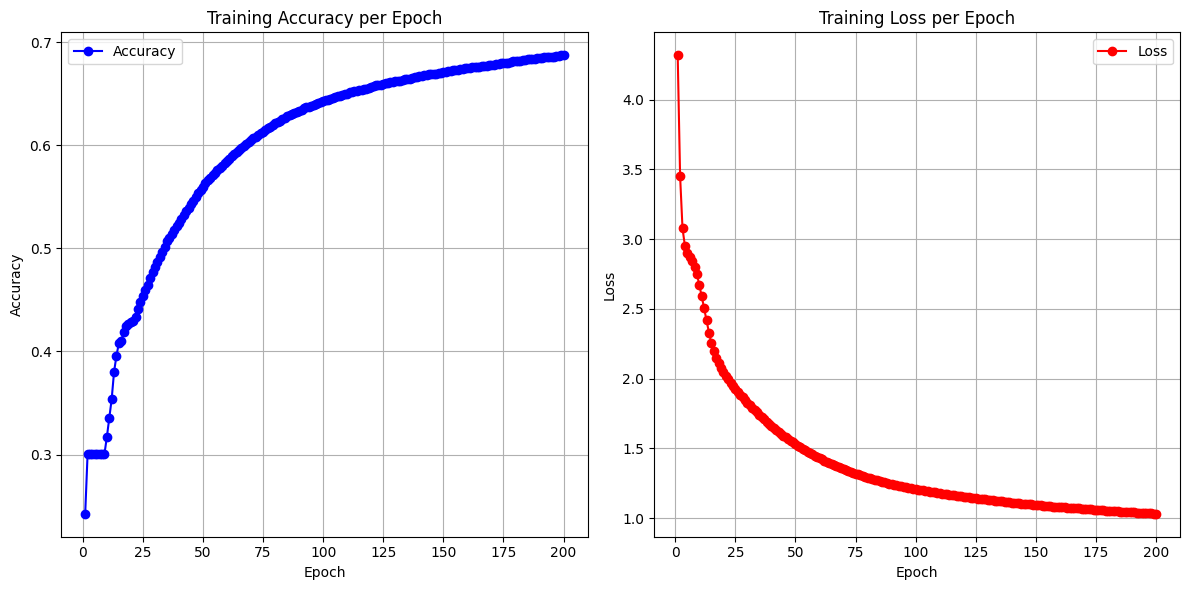

In [77]:
import matplotlib.pyplot as plt

# Pobranie wartości strat i dokładności z historii
loss = history.history['loss']
accuracy = history.history['accuracy']
epochs = range(1, len(loss) + 1)

# Wykres strat i dokładności
plt.figure(figsize=(12, 6))

# Wykres strat
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, marker='o', label='Accuracy', color='blue')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Wykres dokładności
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, marker='o', label='Loss', color='red')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### RESULTS
- bulding the model and applying saved weights
- text generation function
- generate text based on the provided beginning

In [67]:
latest_check= tf.train.latest_checkpoint(checkpoint_dir)

In [68]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(latest_check)

model.build(tf.TensorShape([1, None]))

In [69]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (1, None, 300)            26400     
                                                                 
 gru_6 (GRU)                 (1, None, 256)            428544    
                                                                 
 gru_7 (GRU)                 (1, None, 256)            394752    
                                                                 
 dense_3 (Dense)             (1, None, 88)             22616     
                                                                 
Total params: 872,312
Trainable params: 872,312
Non-trainable params: 0
_________________________________________________________________


In [70]:
def generate_text(model, start_string):

  num_generate = 1000
  input_eval = [char2index[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)
  text_generated = []
  scaling = 0.5

  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      predictions = tf.squeeze(predictions, 0)
      predictions = predictions / scaling
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      input_eval = tf.expand_dims([predicted_id], 0)
      text_generated.append(index2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [71]:
print(generate_text(model, start_string=u"Harry killed Ron "))

Harry killed Ron 
melted  with  side  of  the  water.  For  the  hobbits  leave  the  rust 
of  the  corner  that  is  where  the  country  was  made  some  first  trees  and  seen  here 
and  the  water  and  strong  the  day  was  watched  the  road  and  went  to  the  hills.  Many 
place  was  the  stars  behind  the  wind  in  and  beginning  to  go  with  the  sky  on  the 
spones  of  a  short  ended  of  the  sound  of  day  the  sun  was  reluctantly  to  the  water.  ‘I  am  not  had  not 
believe  the  Ring.  But  only  the  southern  silence  was  not  for  the  stars. 

‘I  will  not  see  the  night  was  over  his  heart  the  Shire,  or  in  the  land  of  Lorien. 

‘Yes,  unless  you  can  were  not  many  much  and  finding  the  ring  was  not  easy  to  trees  and  back  at  last.  ‘I  will  not  hear 
the  smale  and  a  fire  of  the  Ring  is  far  away,  and  many  friends  before  the  shadows  and  was 
the  leaves  of  the  wind  was  in  the  ring  there  wa

In [72]:
print(generate_text(model, start_string=u"Manchaster Uniter just lost the war on Anfield fighting"))

Manchaster Uniter just lost the war on Anfield fighting  in  a  strange  to 
the  hill,  the  steep  shadows  of  the  water,  and  passed  in  the  dark 
leaves  and  the  sleep,  and  the  word  was  riding  on  the  ridge  of  the  Men  of  the 
more  had  off  a  corried  was  here  and  the  light  of  the  Elves  and 
the  flat  half  a  power  of  the  Shire  had  been  deeps  ago  we  have  path  the  fire  and 
dell  and  the  light  of  the  dark  chance,  and  we  could  night  and  silence.  It  was  still  and  drew  at  the  water.  There  was  no  sign  of  which  he 
was  a  path  the  bottom  of  the  dwarf-shoulders.  ‘It  is  little  right,’  he  said.  ‘But 
I  am  good  things  were  here  of  any  course  of  the  way  of  Bag  End.  One  was  stone  and  the 
Shire  with  a  long  thing  that  had  come  for  a  moment  for  you,  and  I  will  see  him  little  for  the  world  is  not  the  shadow  of  the  Ring  in  the  stream.  The  thresho 
warning  the  wi

---

In [73]:
def calculate_cross_entropy_loss(model, test_sequences):
    total_loss = 0
    total_steps = 0
    
    for sequence in test_sequences:
        input_seq = sequence[:-1]
        target_seq = sequence[1:]
        
        input_seq = tf.expand_dims(input_seq, 0)
        
        predictions = model(input_seq)
        
        loss = tf.keras.losses.sparse_categorical_crossentropy(target_seq, predictions[0], from_logits=True)
        
        total_loss += tf.reduce_sum(loss).numpy()
        total_steps += len(target_seq)
    
    avg_loss = total_loss / total_steps
    return avg_loss

In [74]:
# tutaj można załadować inną część tolkiena albo hobbita
first_10_sequences = list(sequences.take(2))

In [75]:
avg_loss = calculate_cross_entropy_loss(model, first_10_sequences)
avg_loss

1.0188643646240234

In [76]:
perplexity = np.exp(avg_loss)
perplexity

2.770047213458992